In [2]:
#in this script we are taking our QC-ed EZ T cell data and using celltypist to annotate it
import scanpy as sc
import anndata as ad
import pandas as pd

In [3]:
import celltypist
from celltypist import models

In [4]:
adata = sc.read_csv(filename='/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/EZ_T/processed/countdata.tsv', delimiter='\t', first_column_names=True )

In [5]:
#adding metadata
# Replace 'path/to/your/metadata.tsv' with the actual path to your metadata file
metadata = pd.read_csv('/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/EZ_T/processed/metadata.csv', index_col=0) #index_col sets first col to be rownames

In [6]:
adata.obs = adata.obs.join(metadata)

In [7]:
print(adata)

AnnData object with n_obs × n_vars = 17822 × 20549
    obs: 'nCount_RNA', 'nFeature_RNA', 'replicate', 'treatment', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'


In [8]:
adata.layers["counts"] = adata.X.copy() #store the raw count data

In [9]:
#normalising gene expression counts before celltypist run
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum = 10000)
# Logarithmize the data
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="batch")

sc.tl.pca(adata)

sc.pp.neighbors(adata)

sc.tl.umap(adata)

# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
#note that in G2G lab notebook they run CellTypist using highly variable genes, but CellTypist documentation recommends all genes
#we will run with all genes

... storing 'replicate' as categorical
... storing 'treatment' as categorical
... storing 'batch' as categorical
/g/data/yr31/hb1618/iPSC_project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
#models.download_models(force_update = True)

In [11]:
models.models_path

'/home/561/hb1618/.celltypist/data/models'

In [12]:
# Select annotation model. We will use pan_fetal_human, as it has effectively been trained using our T cell reference data
#model = models.Model.load(model = '/home/561/hb1618/.celltypist/data/models/Pan_Fetal_Human.pkl')

In [13]:
predictions = celltypist.annotate(adata, model = "Pan_Fetal_Human.pkl", majority_voting = True)

🔬 Input data has 17822 cells and 20549 genes
🔗 Matching reference genes in the model
🧬 5578 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [14]:
adata.obs['celltypist_panfetal_predictions'] = predictions.predicted_labels['majority_voting']
print(adata)
predictions

AnnData object with n_obs × n_vars = 17822 × 20549
    obs: 'nCount_RNA', 'nFeature_RNA', 'replicate', 'treatment', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'celltypist_panfetal_predictions'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'over_clustering'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


CellTypist prediction result for 17822 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 17822 query cells and 138 cell types
    probability_matrix: data frame with 17822 query cells and 138 cell types
    adata: AnnData object referred

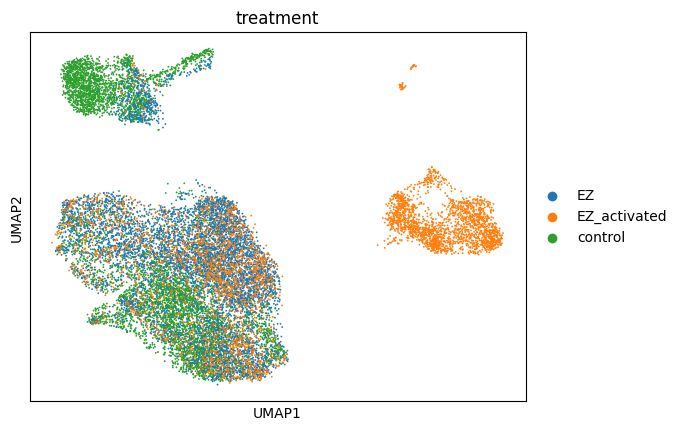

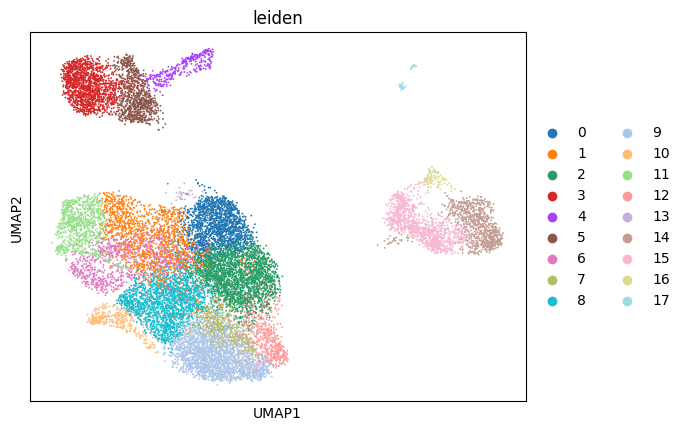

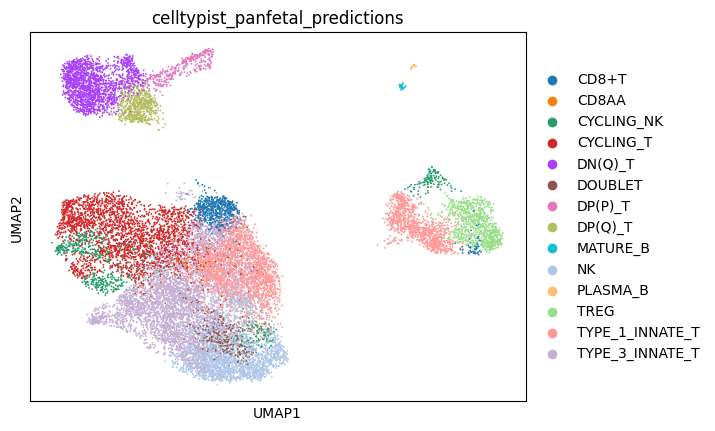

In [15]:
sc.pl.umap(adata,color=['treatment'])
sc.pl.umap(adata,color=['leiden']) #leiden refers to the clusters we generated prior
sc.pl.umap(adata,color='celltypist_panfetal_predictions') #these are our predicted cell types

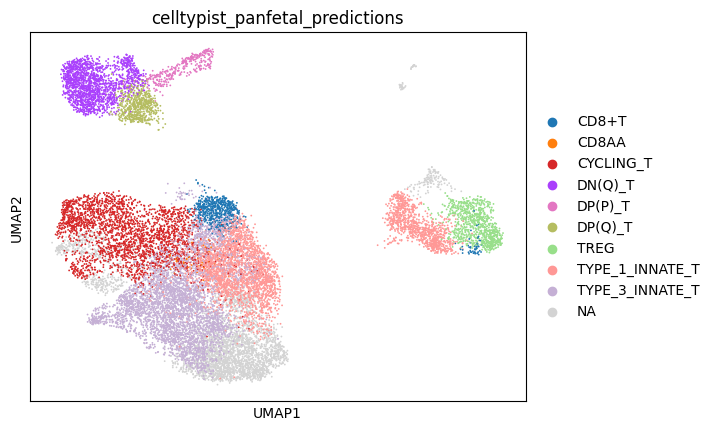

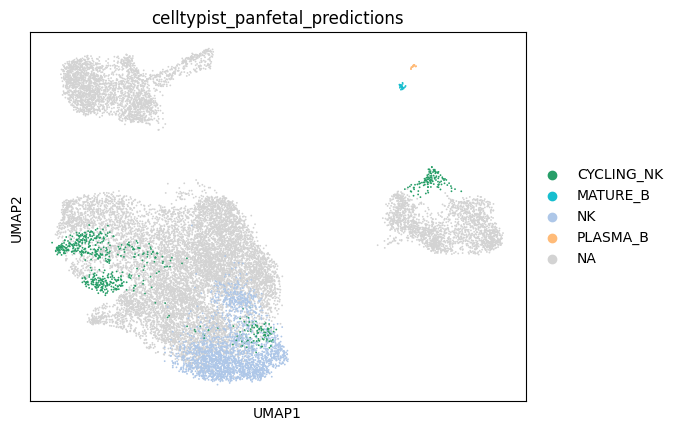

In [16]:
sc.pl.umap(adata,color='celltypist_panfetal_predictions', groups = ["CD8AA", "DP(P)_T", "DP(Q)_T", "CD8+T", "CYCLING_T", "DN(Q)_T", "TYPE_1_INNATE_T", "TYPE_3_INNATE_T", "TREG"])
sc.pl.umap(adata,color='celltypist_panfetal_predictions', groups = ["PLASMA_B", "NK", "CYCLING_NK", "MATURE_B"])

In [17]:
adata_EZ = adata[adata.obs['treatment'].isin(["EZ", "EZ_activated"])].copy() 

In [18]:
print(adata_EZ)

AnnData object with n_obs × n_vars = 10924 × 20549
    obs: 'nCount_RNA', 'nFeature_RNA', 'replicate', 'treatment', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'celltypist_panfetal_predictions'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'over_clustering', 'treatment_colors', 'leiden_colors', 'celltypist_panfetal_predictions_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [19]:
adata_ctrl = adata[adata.obs['treatment'] == "control"].copy() 

In [20]:
print(adata_ctrl)

AnnData object with n_obs × n_vars = 6898 × 20549
    obs: 'nCount_RNA', 'nFeature_RNA', 'replicate', 'treatment', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'celltypist_panfetal_predictions'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'over_clustering', 'treatment_colors', 'leiden_colors', 'celltypist_panfetal_predictions_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


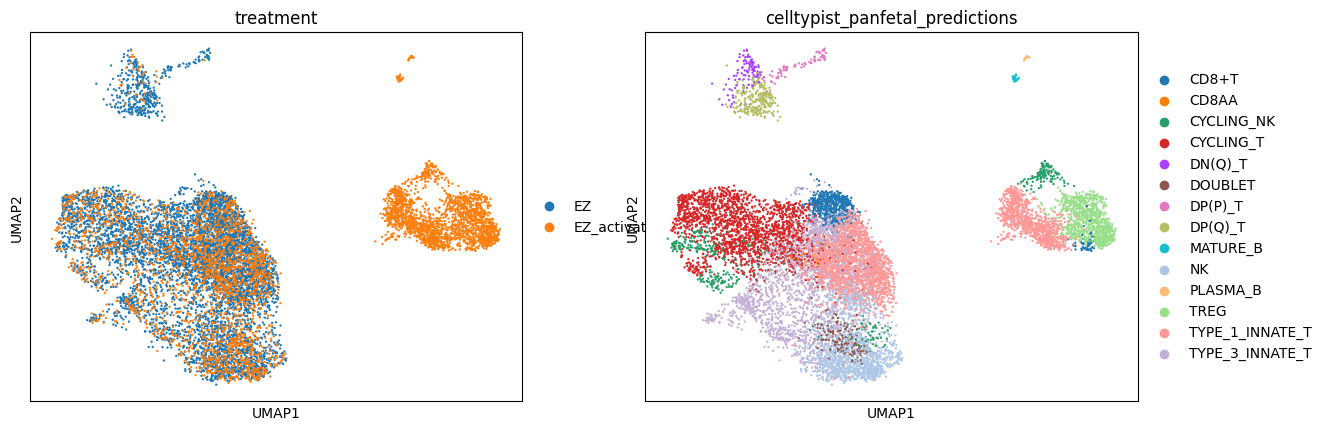

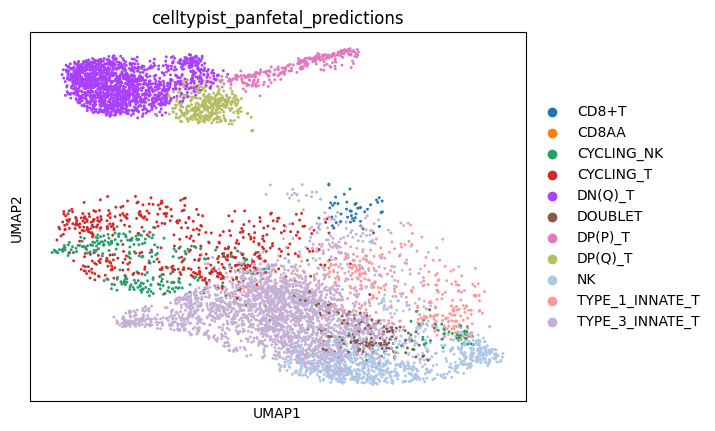

In [21]:
sc.pl.umap(adata_EZ,color=['treatment', 'celltypist_panfetal_predictions'])
sc.pl.umap(adata_ctrl,color='celltypist_panfetal_predictions') #these are our predicted cell types

In [22]:
#experimenting with other models
predictions_high = celltypist.annotate(adata, model = "Immune_All_High.pkl", majority_voting = True)
predictions_low = celltypist.annotate(adata, model = "Immune_All_Low.pkl", majority_voting = True)
predictions_thymus = celltypist.annotate(adata, model = "Developing_Human_Thymus.pkl", majority_voting = True)

🔬 Input data has 17822 cells and 20549 genes
🔗 Matching reference genes in the model
🧬 5255 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 17822 cells and 20549 genes
🔗 Matching reference genes in the model
🧬 5255 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 17822 cells and 20549 genes
🔗 Matching reference genes in the model
🧬 3903 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood g

In [23]:
adata.obs['celltypist_high_predictions'] = predictions_high.predicted_labels['majority_voting']
adata.obs['celltypist_low_predictions'] = predictions_low.predicted_labels['majority_voting']
adata.obs['celltypist_thymus_predictions'] = predictions_thymus.predicted_labels['majority_voting']

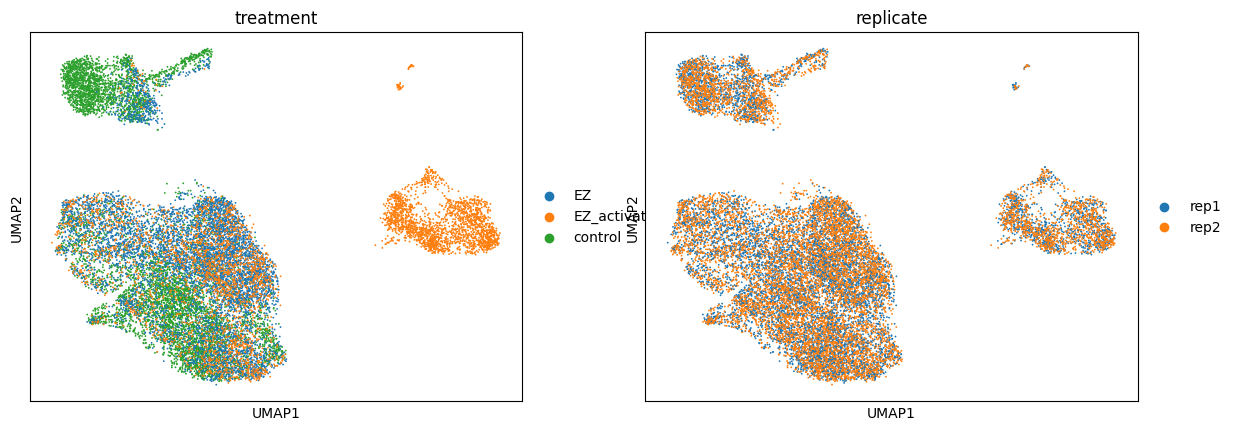

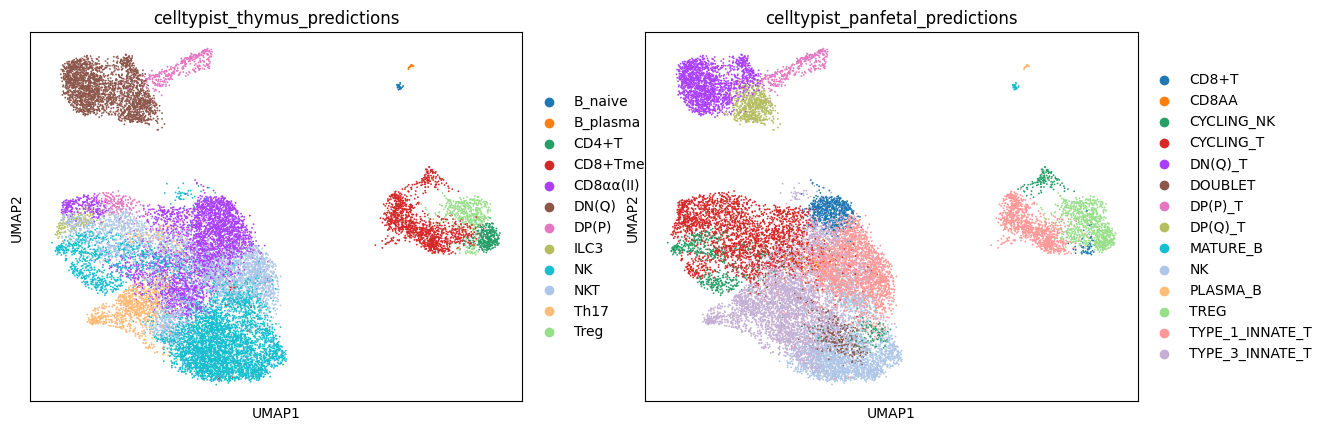

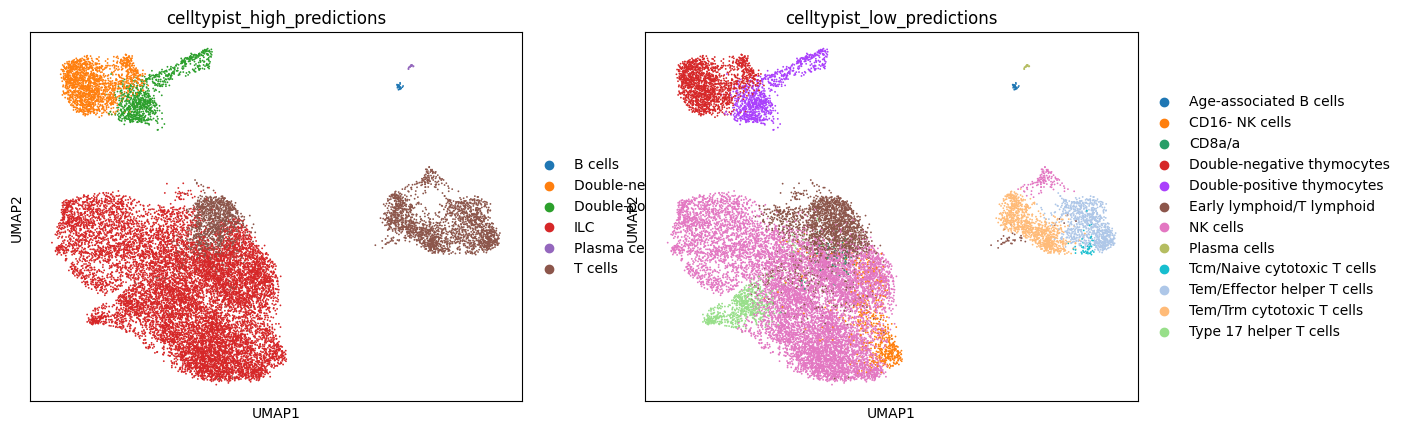

In [24]:
sc.pl.umap(adata,color=['treatment', 'replicate'], legend_loc="right margin")
sc.pl.umap(adata,color=['celltypist_thymus_predictions', 'celltypist_panfetal_predictions'], legend_loc="right margin")
sc.pl.umap(adata,color=['celltypist_high_predictions', 'celltypist_low_predictions'], legend_loc="right margin") #low granularity and high granularity

In [25]:
#exporting metadata
# Save the metadata, containing our new celltypist predictions, to the existing metadata file
adata.obs.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/EZ_T/processed/metadata.csv")